# Predicting Credit Card Fraud


## Goal
- Produce a predictive model as evaluated by Area Under the Precision-Recall Curve and Average Precision Score.

## Process
- Explore Data.
- Split data into validation/training/test sets.
- Select best model based on validation data.
- Evaluate model and perform threshold tuning.
- Perform Bayesian Optimization for hyperparameter tuning.
- Evaluate tuned model and perform threshold tuning.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

plt.style.use('fivethirtyeight')

In [2]:
data = pd.read_csv('./data/creditcard.csv')

## Exploring data
Let's go through the basics and explore this dataset.

In [3]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
data.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [5]:
compare_means = pd.concat([
    data[data['Class'] == 0].mean().round(3),
    data[data['Class'] == 1].mean().round(3)
], axis = 1)

compare_means.columns = ['Legit','Fraud']

compare_means['AbsVar'] = abs(compare_means['Fraud'] - compare_means['Legit'])

compare_means['AbsPct'] = (compare_means['AbsVar'] / compare_means['Legit']).round(3) * 100


In [6]:
compare_means.sort_values(by='AbsVar', ascending=False)

,Legit,Fraud,AbsVar,AbsPct
Time,94838.202,80746.807,14091.395,14.9
Amount,88.291,122.211,33.920,38.4
V3,0.012,-7.033,7.045,58708.3
V14,0.012,-6.972,6.984,58200.0
V17,0.012,-6.666,6.678,55650.0
V12,0.011,-6.259,6.270,57000.0
V10,0.010,-5.677,5.687,56870.0
V7,0.010,-5.569,5.579,55790.0
V1,0.008,-4.772,4.780,59750.0
V4,-0.008,4.542,4.550,-56875.0


In [7]:
compare_std = pd.concat([
    data[data['Class'] == 0].std().round(3),
    data[data['Class'] == 1].std().round(3)
], axis = 1)

compare_std.columns = ['Legit','Fraud']

compare_std['Var'] = compare_std['Fraud'] - compare_std['Legit']

compare_std['AbsPct'] = (compare_std['Var'] / compare_std['Legit']).round(3) * 100

compare_std.columns = ['{}_std'.format(i) for i in compare_std.columns]


In [8]:
compare_std.sort_values(by='AbsPct_std', ascending=False)

,Legit_std,Fraud_std,Var_std,AbsPct_std
V17,0.749,6.971,6.222,830.7
V7,1.179,7.207,6.028,511.3
V8,1.161,6.798,5.637,485.5
V21,0.717,3.869,3.152,439.6
V12,0.946,4.654,3.708,392.0
V3,1.459,7.111,5.652,387.4
V14,0.897,4.279,3.382,377.0
V10,1.044,4.897,3.853,369.1
V16,0.845,3.865,3.020,357.4
V5,1.357,5.372,4.015,295.9


In [9]:
compare_mean_and_std = pd.concat([
    compare_means,
    compare_std
], axis = 1)

In [10]:
compare_mean_and_std['quotient'] = compare_mean_and_std['AbsVar'] / compare_mean_and_std['Var_std']

In [11]:
compare_mean_and_std[
    compare_mean_and_std['quotient'] > 0.75
].sort_values(by='quotient', ascending=False)

,Legit,Fraud,AbsVar,AbsPct,Legit_std,Fraud_std,Var_std,AbsPct_std,quotient
Class,0.000,1.000,1.000,inf,0.000,0.000,0.000,NaN,inf
Time,94838.202,80746.807,14091.395,14.9,47484.016,47835.365,351.349,0.7,40.106546
Amount,88.291,122.211,33.920,38.4,250.105,256.683,6.578,2.6,5.156583
V4,-0.008,4.542,4.550,-56875.0,1.399,2.873,1.474,105.4,3.086839
V6,0.002,-1.398,1.400,70000.0,1.330,1.858,0.528,39.7,2.651515
V11,-0.007,3.800,3.807,-54385.7,1.003,2.679,1.676,167.1,2.271480
V14,0.012,-6.972,6.984,58200.0,0.897,4.279,3.382,377.0,2.065050
V9,0.004,-2.581,2.585,64625.0,1.089,2.501,1.412,129.7,1.830737
V12,0.011,-6.259,6.270,57000.0,0.946,4.654,3.708,392.0,1.690939
V10,0.010,-5.677,5.687,56870.0,1.044,4.897,3.853,369.1,1.475993


In [12]:
high_var_feats = compare_mean_and_std[
    compare_mean_and_std['quotient'] > 0.75
].sort_values(by='quotient', ascending=False).index

In [13]:
high_var_feats

Index(['Class', 'Time', 'Amount', 'V4', 'V6', 'V11', 'V14', 'V9', 'V12', 'V10',
       'V16', 'V2', 'V3', 'V18', 'V17', 'V13', 'V1', 'V19', 'V7', 'V5'],
      dtype='object')

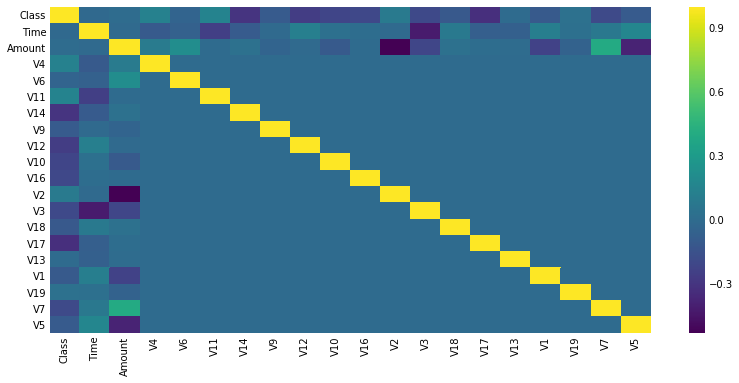

In [14]:
plt.figure(figsize=(12,6))
sns.heatmap(data[high_var_feats].corr(),cmap='viridis')

In [15]:
# Compare distributions of the Classes
# Custom script; work can be seen in MyDataTools.py available in the same repo as this notebook
from MyDataTools import explore

In [16]:
e = explore()

-----
Col Name: Time
Total values: 284807
Floor: -15643.568 (0 values; 0.00%)
Cap: 205271.287 (0 values; 0.00%)


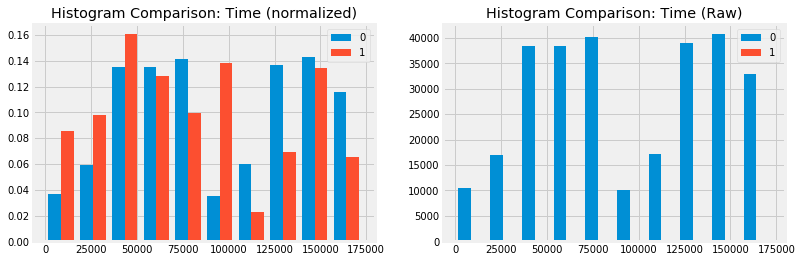

Raw Hist:
                0     1
0.0       10468.0  42.0
17279.2   16907.0  48.0
34558.4   38447.0  79.0
51837.6   38487.0  63.0
69116.8   40194.0  49.0
86396.0   10077.0  68.0
103675.2  17150.0  11.0
120954.4  38917.0  34.0
138233.6  40713.0  66.0
155512.8  32955.0  32.0

Norm Hist:
              0      1
0.0       0.037  0.085
17279.2   0.059  0.098
34558.4   0.135  0.161
51837.6   0.135  0.128
69116.8   0.141  0.100
86396.0   0.035  0.138
103675.2  0.060  0.022
120954.4  0.137  0.069
138233.6  0.143  0.134
155512.8  0.116  0.065

Value Counts from DF:
0    284315
1       492
Name: Class, dtype: int64

Value Counts from Hist:
0    284315.0
1       492.0
dtype: float64

-----
Col Name: V1
Total values: 284807
Floor: -4.556 (6233 values; 2.19%)
Cap: 4.556 (0 values; 0.00%)


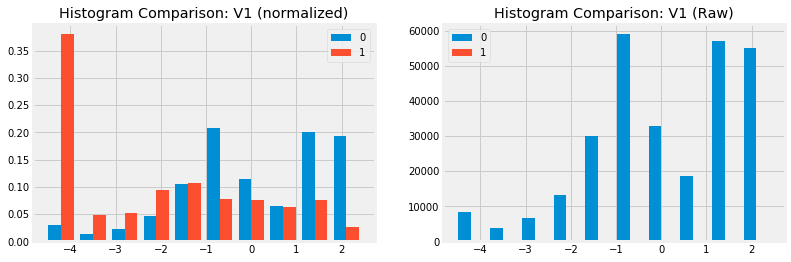

Raw Hist:
             0      1
-4.56   8394.0  187.0
-3.85   3676.0   24.0
-3.15   6653.0   26.0
-2.45  13097.0   46.0
-1.75  29886.0   53.0
-1.05  59042.0   38.0
-0.35  32738.0   37.0
 0.35  18643.0   31.0
 1.05  57014.0   37.0
 1.75  55172.0   13.0

Norm Hist:
           0      1
-4.56  0.030  0.380
-3.85  0.013  0.049
-3.15  0.023  0.053
-2.45  0.046  0.093
-1.75  0.105  0.108
-1.05  0.208  0.077
-0.35  0.115  0.075
 0.35  0.066  0.063
 1.05  0.201  0.075
 1.75  0.194  0.026

Value Counts from DF:
0    284315
1       492
Name: Class, dtype: int64

Value Counts from Hist:
0    284315.0
1       492.0
dtype: float64

-----
Col Name: V2
Total values: 284807
Floor: -3.841 (4650 values; 1.63%)
Cap: 3.841 (2792 values; 0.98%)


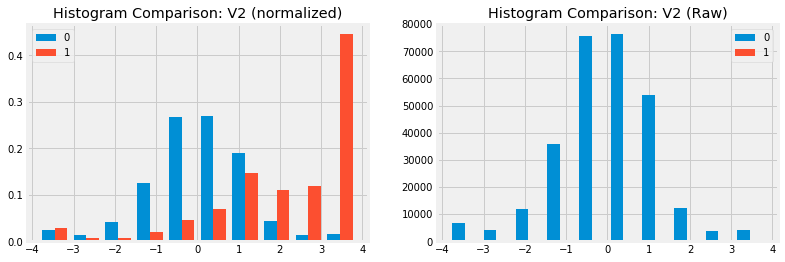

Raw Hist:
             0      1
-3.84   6814.0   14.0
-3.07   4011.0    4.0
-2.30  11937.0    4.0
-1.54  35674.0   10.0
-0.77  75728.0   22.0
 0.00  76274.0   34.0
 0.77  53726.0   72.0
 1.54  12176.0   54.0
 2.30   3631.0   59.0
 3.07   4344.0  219.0

Norm Hist:
           0      1
-3.84  0.024  0.028
-3.07  0.014  0.008
-2.30  0.042  0.008
-1.54  0.125  0.020
-0.77  0.266  0.045
 0.00  0.268  0.069
 0.77  0.189  0.146
 1.54  0.043  0.110
 2.30  0.013  0.120
 3.07  0.015  0.445

Value Counts from DF:
0    284315
1       492
Name: Class, dtype: int64

Value Counts from Hist:
0    284315.0
1       492.0
dtype: float64

-----
Col Name: V3
Total values: 284807
Floor: -3.527 (4094 values; 1.44%)
Cap: 3.527 (176 values; 0.06%)


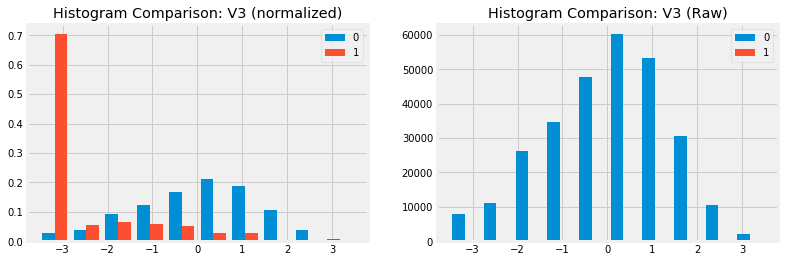

Raw Hist:
             0      1
-3.53   8060.0  346.0
-2.82  11116.0   28.0
-2.12  26332.0   32.0
-1.41  34573.0   29.0
-0.71  47622.0   25.0
-0.00  60163.0   14.0
 0.71  53255.0   14.0
 1.41  30451.0    3.0
 2.12  10562.0    1.0
 2.82   2181.0    0.0

Norm Hist:
           0      1
-3.53  0.028  0.703
-2.82  0.039  0.057
-2.12  0.093  0.065
-1.41  0.122  0.059
-0.71  0.167  0.051
-0.00  0.212  0.028
 0.71  0.187  0.028
 1.41  0.107  0.006
 2.12  0.037  0.002
 2.82  0.008  0.000

Value Counts from DF:
0    284315
1       492
Name: Class, dtype: int64

Value Counts from Hist:
0    284315.0
1       492.0
dtype: float64

-----
Col Name: V4
Total values: 284807
Floor: -3.293 (2002 values; 0.70%)
Cap: 3.293 (8148 values; 2.86%)


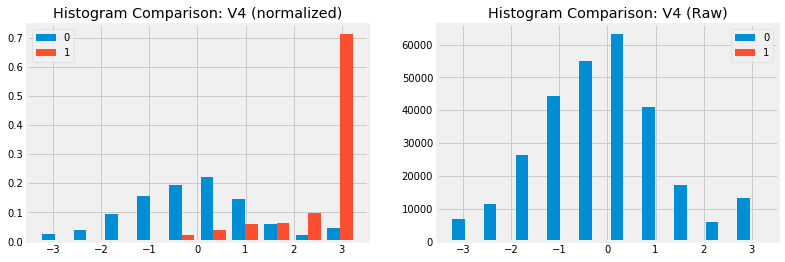

Raw Hist:
             0      1
-3.29   6915.0    0.0
-2.63  11508.0    0.0
-1.98  26261.0    0.0
-1.32  44279.0    3.0
-0.66  55128.0   11.0
 0.00  63147.0   19.0
 0.66  40999.0   30.0
 1.32  17112.0   31.0
 1.98   5884.0   48.0
 2.63  13082.0  350.0

Norm Hist:
           0      1
-3.29  0.024  0.000
-2.63  0.040  0.000
-1.98  0.092  0.000
-1.32  0.156  0.006
-0.66  0.194  0.022
 0.00  0.222  0.039
 0.66  0.144  0.061
 1.32  0.060  0.063
 1.98  0.021  0.098
 2.63  0.046  0.711

Value Counts from DF:
0    284315
1       492
Name: Class, dtype: int64

Value Counts from Hist:
0    284315.0
1       492.0
dtype: float64

-----
Col Name: V5
Total values: 284807
Floor: -3.210 (2578 values; 0.91%)
Cap: 3.210 (3653 values; 1.28%)


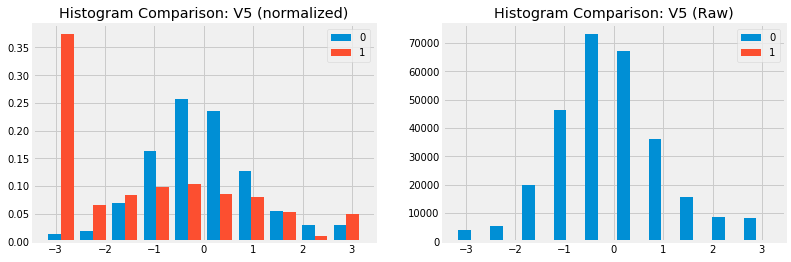

Raw Hist:
             0      1
-3.21   3998.0  184.0
-2.57   5377.0   32.0
-1.93  19708.0   41.0
-1.28  46424.0   48.0
-0.64  73065.0   51.0
 0.00  67096.0   42.0
 0.64  36138.0   39.0
 1.28  15699.0   26.0
 1.93   8436.0    5.0
 2.57   8374.0   24.0

Norm Hist:
           0      1
-3.21  0.014  0.374
-2.57  0.019  0.065
-1.93  0.069  0.083
-1.28  0.163  0.098
-0.64  0.257  0.104
 0.00  0.236  0.085
 0.64  0.127  0.079
 1.28  0.055  0.053
 1.93  0.030  0.010
 2.57  0.029  0.049

Value Counts from DF:
0    284315
1       492
Name: Class, dtype: int64

Value Counts from Hist:
0    284315.0
1       492.0
dtype: float64

-----
Col Name: V6
Total values: 284807
Floor: -3.099 (1072 values; 0.38%)
Cap: 3.099 (15095 values; 5.30%)


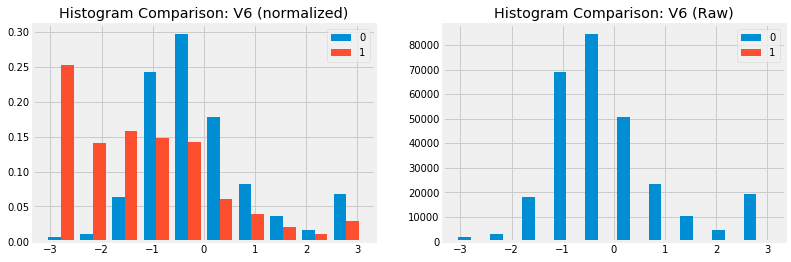

Raw Hist:
             0      1
-3.10   1700.0  124.0
-2.48   2788.0   69.0
-1.86  18244.0   78.0
-1.24  69092.0   73.0
-0.62  84395.0   70.0
 0.00  50678.0   30.0
 0.62  23445.0   19.0
 1.24  10269.0   10.0
 1.86   4469.0    5.0
 2.48  19235.0   14.0

Norm Hist:
           0      1
-3.10  0.006  0.252
-2.48  0.010  0.140
-1.86  0.064  0.159
-1.24  0.243  0.148
-0.62  0.297  0.142
 0.00  0.178  0.061
 0.62  0.082  0.039
 1.24  0.036  0.020
 1.86  0.016  0.010
 2.48  0.068  0.028

Value Counts from DF:
0    284315
1       492
Name: Class, dtype: int64

Value Counts from Hist:
0    284315.0
1       492.0
dtype: float64

-----
Col Name: V7
Total values: 284807
Floor: -2.877 (3076 values; 1.08%)
Cap: 2.877 (2512 values; 0.88%)


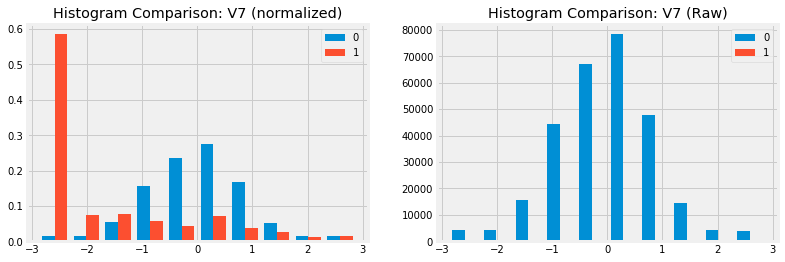

Raw Hist:
             0      1
-2.88   4295.0  288.0
-2.30   4290.0   36.0
-1.73  15468.0   38.0
-1.15  44325.0   28.0
-0.58  67063.0   21.0
 0.00  78326.0   35.0
 0.58  47916.0   19.0
 1.15  14383.0   13.0
 1.73   4289.0    6.0
 2.30   3960.0    8.0

Norm Hist:
           0      1
-2.88  0.015  0.585
-2.30  0.015  0.073
-1.73  0.054  0.077
-1.15  0.156  0.057
-0.58  0.236  0.043
 0.00  0.275  0.071
 0.58  0.169  0.039
 1.15  0.051  0.026
 1.73  0.015  0.012
 2.30  0.014  0.016

Value Counts from DF:
0    284315
1       492
Name: Class, dtype: int64

Value Counts from Hist:
0    284315.0
1       492.0
dtype: float64

-----
Col Name: V8
Total values: 284807
Floor: -2.778 (4581 values; 1.61%)
Cap: 2.778 (1617 values; 0.57%)


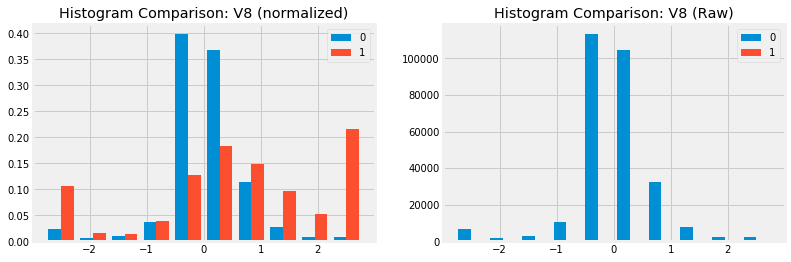

Raw Hist:
              0      1
-2.78    6633.0   52.0
-2.22    1977.0    8.0
-1.67    2717.0    7.0
-1.11   10805.0   19.0
-0.56  113240.0   63.0
 0.00  104490.0   90.0
 0.56   32232.0   73.0
 1.11    7800.0   48.0
 1.67    2093.0   26.0
 2.22    2328.0  106.0

Norm Hist:
           0      1
-2.78  0.023  0.106
-2.22  0.007  0.016
-1.67  0.010  0.014
-1.11  0.038  0.039
-0.56  0.398  0.128
 0.00  0.368  0.183
 0.56  0.113  0.148
 1.11  0.027  0.098
 1.67  0.007  0.053
 2.22  0.008  0.215

Value Counts from DF:
0    284315
1       492
Name: Class, dtype: int64

Value Counts from Hist:
0    284315.0
1       492.0
dtype: float64

-----
Col Name: V9
Total values: 284807
Floor: -2.555 (2051 values; 0.72%)
Cap: 2.555 (4979 values; 1.75%)


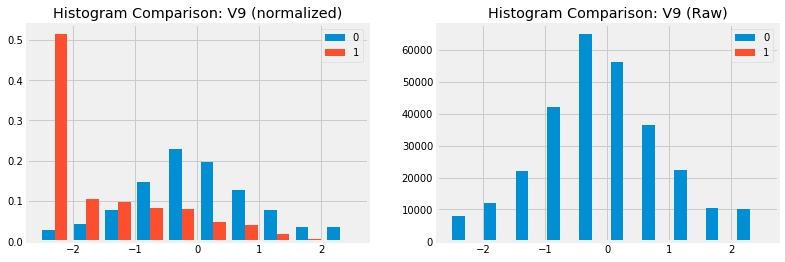

Raw Hist:
             0      1
-2.56   7921.0  253.0
-2.04  11942.0   52.0
-1.53  22174.0   48.0
-1.02  42057.0   41.0
-0.51  64927.0   40.0
-0.00  56264.0   24.0
 0.51  36420.0   20.0
 1.02  22337.0    9.0
 1.53  10290.0    3.0
 2.04   9983.0    2.0

Norm Hist:
           0      1
-2.56  0.028  0.514
-2.04  0.042  0.106
-1.53  0.078  0.098
-1.02  0.148  0.083
-0.51  0.228  0.081
-0.00  0.198  0.049
 0.51  0.128  0.041
 1.02  0.079  0.018
 1.53  0.036  0.006
 2.04  0.035  0.004

Value Counts from DF:
0    284315
1       492
Name: Class, dtype: int64

Value Counts from Hist:
0    284315.0
1       492.0
dtype: float64

-----
Col Name: V10
Total values: 284807
Floor: -2.533 (1375 values; 0.48%)
Cap: 2.533 (4122 values; 1.45%)


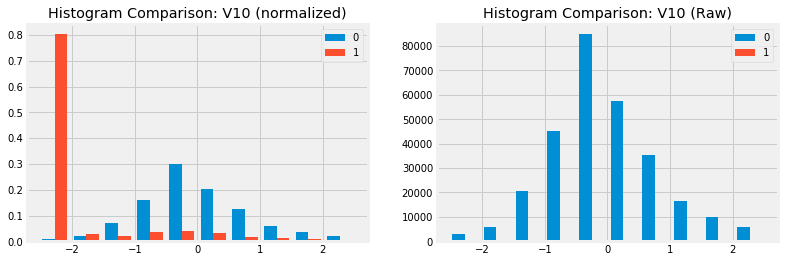

Raw Hist:
             0      1
-2.53   2921.0  395.0
-2.03   5996.0   13.0
-1.52  20496.0   10.0
-1.01  45262.0   17.0
-0.51  84792.0   20.0
 0.00  57415.0   16.0
 0.51  35429.0    8.0
 1.01  16513.0    6.0
 1.52   9748.0    4.0
 2.03   5743.0    3.0

Norm Hist:
           0      1
-2.53  0.010  0.803
-2.03  0.021  0.026
-1.52  0.072  0.020
-1.01  0.159  0.035
-0.51  0.298  0.041
 0.00  0.202  0.033
 0.51  0.125  0.016
 1.01  0.058  0.012
 1.52  0.034  0.008
 2.03  0.020  0.006

Value Counts from DF:
0    284315
1       492
Name: Class, dtype: int64

Value Counts from Hist:
0    284315.0
1       492.0
dtype: float64

-----
Col Name: V11
Total values: 284807
Floor: -2.374 (1074 values; 0.38%)
Cap: 2.374 (2368 values; 0.83%)


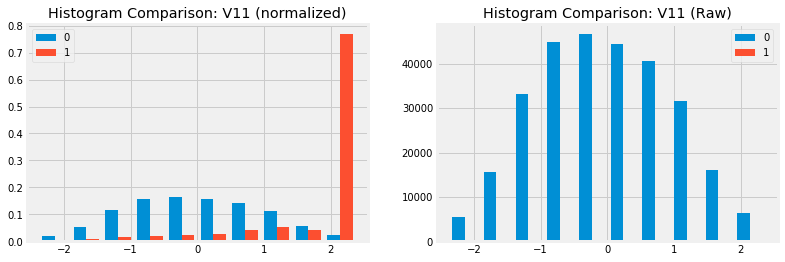

Raw Hist:
             0      1
-2.37   5374.0    0.0
-1.90  15515.0    5.0
-1.42  33135.0    7.0
-0.95  44930.0    9.0
-0.47  46646.0   11.0
 0.00  44379.0   14.0
 0.47  40521.0   20.0
 0.95  31515.0   27.0
 1.42  16019.0   21.0
 1.90   6281.0  378.0

Norm Hist:
           0      1
-2.37  0.019  0.000
-1.90  0.055  0.010
-1.42  0.117  0.014
-0.95  0.158  0.018
-0.47  0.164  0.022
 0.00  0.156  0.028
 0.47  0.143  0.041
 0.95  0.111  0.055
 1.42  0.056  0.043
 1.90  0.022  0.768

Value Counts from DF:
0    284315
1       492
Name: Class, dtype: int64

Value Counts from Hist:
0    284315.0
1       492.0
dtype: float64

-----
Col Name: V12
Total values: 284807
Floor: -2.324 (9484 values; 3.33%)
Cap: 2.324 (549 values; 0.19%)


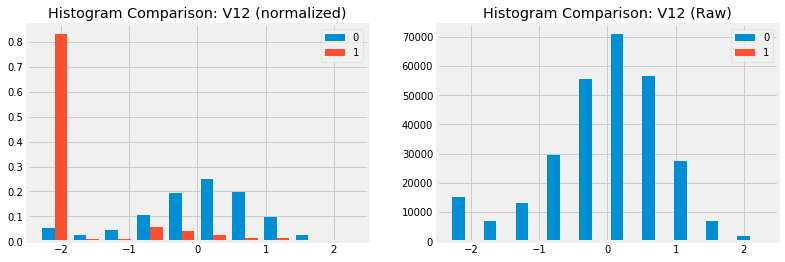

Raw Hist:
             0      1
-2.32  15286.0  409.0
-1.86   7103.0    5.0
-1.39  13185.0    4.0
-0.93  29612.0   28.0
-0.46  55436.0   21.0
-0.00  70866.0   12.0
 0.46  56661.0    7.0
 0.93  27627.0    6.0
 1.39   6843.0    0.0
 1.86   1696.0    0.0

Norm Hist:
           0      1
-2.32  0.054  0.831
-1.86  0.025  0.010
-1.39  0.046  0.008
-0.93  0.104  0.057
-0.46  0.195  0.043
-0.00  0.249  0.024
 0.46  0.199  0.014
 0.93  0.097  0.012
 1.39  0.024  0.000
 1.86  0.006  0.000

Value Counts from DF:
0    284315
1       492
Name: Class, dtype: int64

Value Counts from Hist:
0    284315.0
1       492.0
dtype: float64

-----
Col Name: V13
Total values: 284807
Floor: -2.315 (2604 values; 0.91%)
Cap: 2.315 (4096 values; 1.44%)


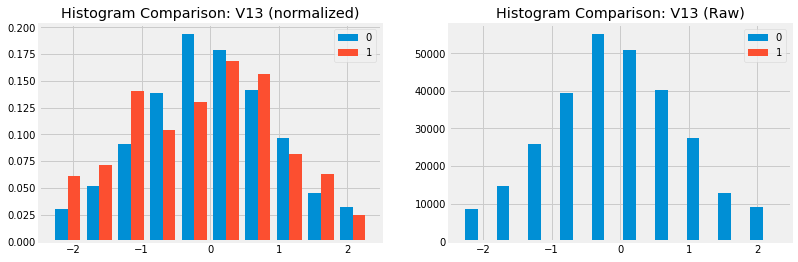

Raw Hist:
             0     1
-2.32   8703.0  30.0
-1.85  14701.0  35.0
-1.39  25987.0  69.0
-0.93  39429.0  51.0
-0.46  55054.0  64.0
 0.00  50965.0  83.0
 0.46  40246.0  77.0
 0.93  27355.0  40.0
 1.39  12884.0  31.0
 1.85   8991.0  12.0

Norm Hist:
           0      1
-2.32  0.031  0.061
-1.85  0.052  0.071
-1.39  0.091  0.140
-0.93  0.139  0.104
-0.46  0.194  0.130
 0.00  0.179  0.169
 0.46  0.142  0.157
 0.93  0.096  0.081
 1.39  0.045  0.063
 1.85  0.032  0.024

Value Counts from DF:
0    284315
1       492
Name: Class, dtype: int64

Value Counts from Hist:
0    284315.0
1       492.0
dtype: float64

-----
Col Name: V14
Total values: 284807
Floor: -2.230 (5359 values; 1.88%)
Cap: 2.230 (2337 values; 0.82%)


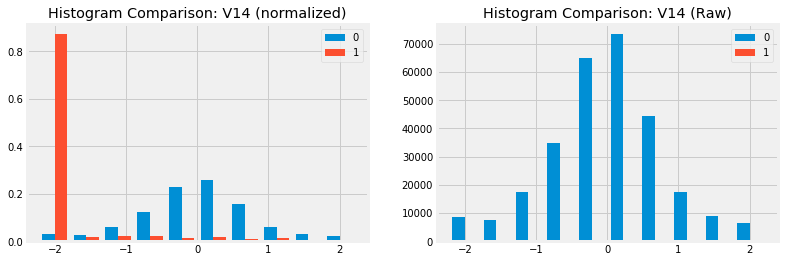

Raw Hist:
             0      1
-2.23   8530.0  429.0
-1.78   7670.0    9.0
-1.34  17417.0   12.0
-0.89  34800.0   11.0
-0.45  64877.0    7.0
 0.00  73396.0    9.0
 0.45  44518.0    5.0
 0.89  17506.0    7.0
 1.34   9140.0    2.0
 1.78   6461.0    1.0

Norm Hist:
           0      1
-2.23  0.030  0.872
-1.78  0.027  0.018
-1.34  0.061  0.024
-0.89  0.122  0.022
-0.45  0.228  0.014
 0.00  0.258  0.018
 0.45  0.157  0.010
 0.89  0.062  0.014
 1.34  0.032  0.004
 1.78  0.023  0.002

Value Counts from DF:
0    284315
1       492
Name: Class, dtype: int64

Value Counts from Hist:
0    284315.0
1       492.0
dtype: float64

-----
Col Name: V15
Total values: 284807
Floor: -2.129 (5243 values; 1.84%)
Cap: 2.129 (1528 values; 0.54%)


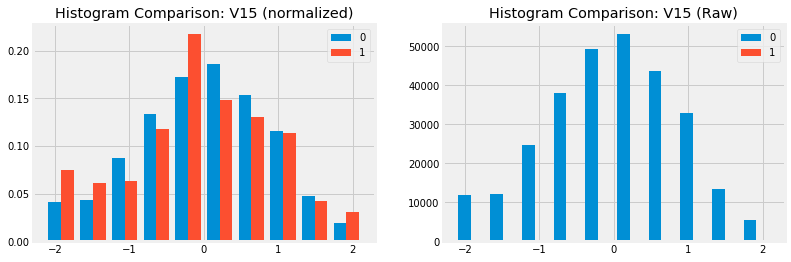

Raw Hist:
             0      1
-2.13  11771.0   37.0
-1.70  12222.0   30.0
-1.28  24750.0   31.0
-0.85  38029.0   58.0
-0.43  49199.0  107.0
 0.00  53064.0   73.0
 0.43  43657.0   64.0
 0.85  32832.0   56.0
 1.28  13449.0   21.0
 1.70   5342.0   15.0

Norm Hist:
           0      1
-2.13  0.041  0.075
-1.70  0.043  0.061
-1.28  0.087  0.063
-0.85  0.134  0.118
-0.43  0.173  0.217
 0.00  0.187  0.148
 0.43  0.154  0.130
 0.85  0.115  0.114
 1.28  0.047  0.043
 1.70  0.019  0.030

Value Counts from DF:
0    284315
1       492
Name: Class, dtype: int64

Value Counts from Hist:
0    284315.0
1       492.0
dtype: float64

-----
Col Name: V16
Total values: 284807
Floor: -2.038 (5600 values; 1.97%)
Cap: 2.038 (1525 values; 0.54%)


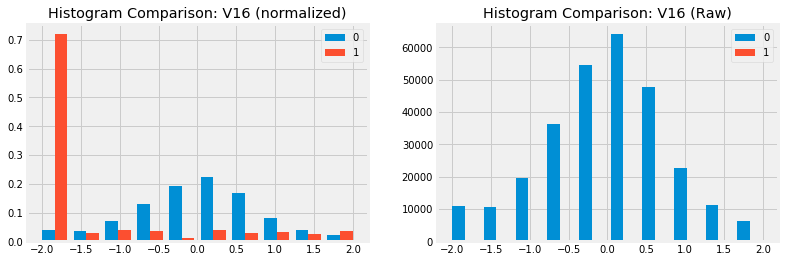

Raw Hist:
             0      1
-2.04  11019.0  354.0
-1.63  10456.0   15.0
-1.22  19671.0   20.0
-0.82  36389.0   17.0
-0.41  54605.0    6.0
 0.00  64012.0   20.0
 0.41  47835.0   15.0
 0.82  22617.0   16.0
 1.22  11343.0   12.0
 1.63   6368.0   17.0

Norm Hist:
           0      1
-2.04  0.039  0.720
-1.63  0.037  0.030
-1.22  0.069  0.041
-0.82  0.128  0.035
-0.41  0.192  0.012
 0.00  0.225  0.041
 0.41  0.168  0.030
 0.82  0.080  0.033
 1.22  0.040  0.024
 1.63  0.022  0.035

Value Counts from DF:
0    284315
1       492
Name: Class, dtype: int64

Value Counts from Hist:
0    284315.0
1       492.0
dtype: float64

-----
Col Name: V17
Total values: 284807
Floor: -1.976 (629 values; 0.22%)
Cap: 1.976 (4505 values; 1.58%)


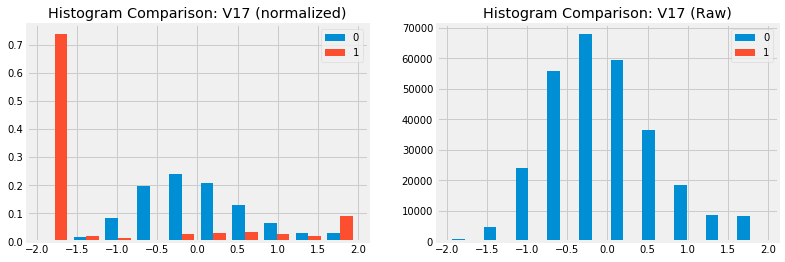

Raw Hist:
             0      1
-1.98    860.0  363.0
-1.58   4750.0   10.0
-1.19  23950.0    6.0
-0.79  55814.0    3.0
-0.40  67866.0   13.0
-0.00  59376.0   14.0
 0.40  36499.0   17.0
 0.79  18370.0   12.0
 1.19   8582.0    9.0
 1.58   8248.0   45.0

Norm Hist:
           0      1
-1.98  0.003  0.738
-1.58  0.017  0.020
-1.19  0.084  0.012
-0.79  0.196  0.006
-0.40  0.239  0.026
-0.00  0.209  0.028
 0.40  0.128  0.035
 0.79  0.065  0.024
 1.19  0.030  0.018
 1.58  0.029  0.091

Value Counts from DF:
0    284315
1       492
Name: Class, dtype: int64

Value Counts from Hist:
0    284315.0
1       492.0
dtype: float64

-----
Col Name: V18
Total values: 284807
Floor: -1.950 (4533 values; 1.59%)
Cap: 1.950 (4079 values; 1.43%)


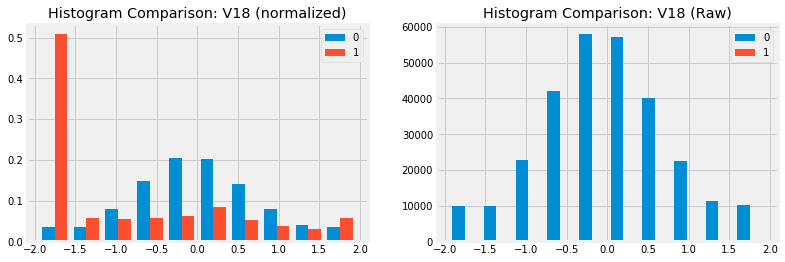

Raw Hist:
             0      1
-1.95   9790.0  250.0
-1.56   9868.0   28.0
-1.17  22873.0   27.0
-0.78  42049.0   28.0
-0.39  57999.0   30.0
 0.00  57355.0   42.0
 0.39  40242.0   26.0
 0.78  22559.0   18.0
 1.17  11356.0   15.0
 1.56  10224.0   28.0

Norm Hist:
           0      1
-1.95  0.034  0.508
-1.56  0.035  0.057
-1.17  0.080  0.055
-0.78  0.148  0.057
-0.39  0.204  0.061
 0.00  0.202  0.085
 0.39  0.142  0.053
 0.78  0.079  0.037
 1.17  0.040  0.030
 1.56  0.036  0.057

Value Counts from DF:
0    284315
1       492
Name: Class, dtype: int64

Value Counts from Hist:
0    284315.0
1       492.0
dtype: float64

-----
Col Name: V19
Total values: 284807
Floor: -1.893 (4304 values; 1.51%)
Cap: 1.893 (4699 values; 1.65%)


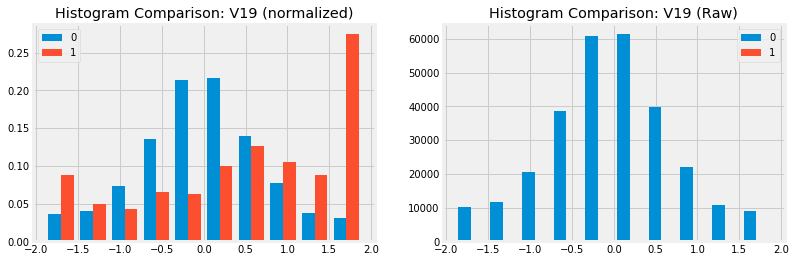

Raw Hist:
             0      1
-1.89  10153.0   43.0
-1.51  11553.0   24.0
-1.14  20678.0   21.0
-0.76  38542.0   32.0
-0.38  60727.0   31.0
 0.00  61358.0   49.0
 0.38  39679.0   62.0
 0.76  22067.0   52.0
 1.14  10627.0   43.0
 1.51   8931.0  135.0

Norm Hist:
           0      1
-1.89  0.036  0.087
-1.51  0.041  0.049
-1.14  0.073  0.043
-0.76  0.136  0.065
-0.38  0.214  0.063
 0.00  0.216  0.100
 0.38  0.140  0.126
 0.76  0.078  0.106
 1.14  0.037  0.087
 1.51  0.031  0.274

Value Counts from DF:
0    284315
1       492
Name: Class, dtype: int64

Value Counts from Hist:
0    284315.0
1       492.0
dtype: float64

-----
Col Name: V20
Total values: 284807
Floor: -1.793 (2323 values; 0.82%)
Cap: 1.793 (4890 values; 1.72%)


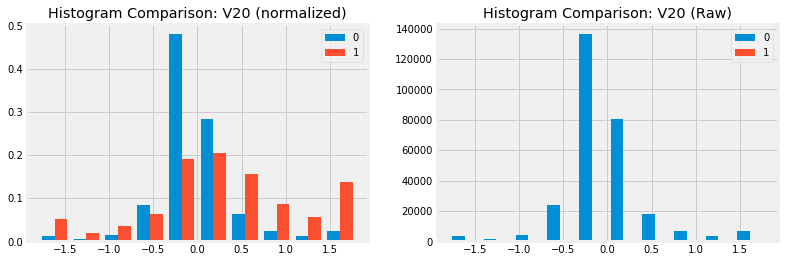

Raw Hist:
              0      1
-1.79    3227.0   25.0
-1.43    1648.0   10.0
-1.08    3999.0   17.0
-0.72   23770.0   31.0
-0.36  136309.0   94.0
 0.00   80500.0  101.0
 0.36   17983.0   77.0
 0.72    6535.0   42.0
 1.08    3504.0   28.0
 1.43    6840.0   67.0

Norm Hist:
           0      1
-1.79  0.011  0.051
-1.43  0.006  0.020
-1.08  0.014  0.035
-0.72  0.084  0.063
-0.36  0.479  0.191
 0.00  0.283  0.205
 0.36  0.063  0.157
 0.72  0.023  0.085
 1.08  0.012  0.057
 1.43  0.024  0.136

Value Counts from DF:
0    284315
1       492
Name: Class, dtype: int64

Value Counts from Hist:
0    284315.0
1       492.0
dtype: float64

-----
Col Name: V21
Total values: 284807
Floor: -1.709 (2081 values; 0.73%)
Cap: 1.709 (3297 values; 1.16%)


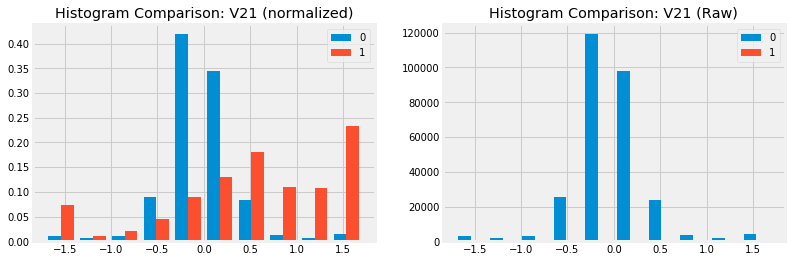

Raw Hist:
              0      1
-1.71    3312.0   36.0
-1.37    1919.0    5.0
-1.03    3255.0   10.0
-0.68   25486.0   22.0
-0.34  119107.0   44.0
 0.00   97958.0   64.0
 0.34   23562.0   89.0
 0.68    3877.0   54.0
 1.03    1612.0   53.0
 1.37    4227.0  115.0

Norm Hist:
           0      1
-1.71  0.012  0.073
-1.37  0.007  0.010
-1.03  0.011  0.020
-0.68  0.090  0.045
-0.34  0.419  0.089
 0.00  0.345  0.130
 0.34  0.083  0.181
 0.68  0.014  0.110
 1.03  0.006  0.108
 1.37  0.015  0.234

Value Counts from DF:
0    284315
1       492
Name: Class, dtype: int64

Value Counts from Hist:
0    284315.0
1       492.0
dtype: float64

-----
Col Name: V22
Total values: 284807
Floor: -1.688 (2633 values; 0.92%)
Cap: 1.688 (1586 values; 0.56%)


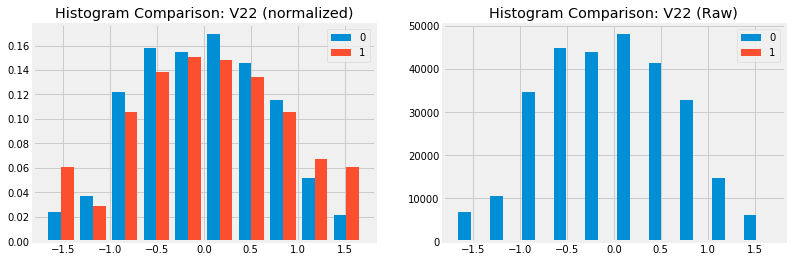

Raw Hist:
             0     1
-1.69   6735.0  30.0
-1.35  10516.0  14.0
-1.01  34798.0  52.0
-0.68  45030.0  68.0
-0.34  44085.0  74.0
-0.00  48120.0  73.0
 0.34  41354.0  66.0
 0.68  32934.0  52.0
 1.01  14709.0  33.0
 1.35   6034.0  30.0

Norm Hist:
           0      1
-1.69  0.024  0.061
-1.35  0.037  0.028
-1.01  0.122  0.106
-0.68  0.158  0.138
-0.34  0.155  0.150
-0.00  0.169  0.148
 0.34  0.145  0.134
 0.68  0.116  0.106
 1.01  0.052  0.067
 1.35  0.021  0.061

Value Counts from DF:
0    284315
1       492
Name: Class, dtype: int64

Value Counts from Hist:
0    284315.0
1       492.0
dtype: float64

-----
Col Name: V23
Total values: 284807
Floor: -1.452 (2125 values; 0.75%)
Cap: 1.452 (3031 values; 1.06%)


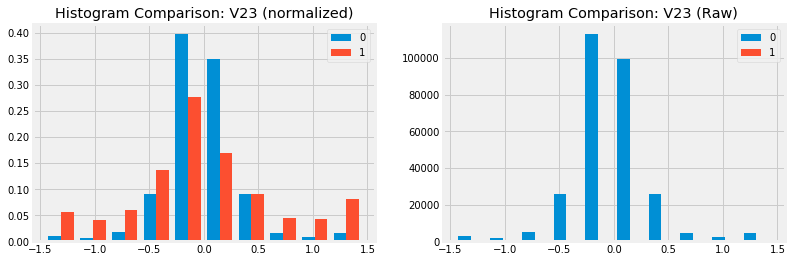

Raw Hist:
              0      1
-1.45    2937.0   28.0
-1.16    1584.0   20.0
-0.87    4953.0   30.0
-0.58   25708.0   67.0
-0.29  112937.0  136.0
 0.00   99426.0   83.0
 0.29   25762.0   45.0
 0.58    4517.0   22.0
 0.87    2198.0   21.0
 1.16    4293.0   40.0

Norm Hist:
           0      1
-1.45  0.010  0.057
-1.16  0.006  0.041
-0.87  0.017  0.061
-0.58  0.090  0.136
-0.29  0.397  0.276
 0.00  0.350  0.169
 0.29  0.091  0.091
 0.58  0.016  0.045
 0.87  0.008  0.043
 1.16  0.015  0.081

Value Counts from DF:
0    284315
1       492
Name: Class, dtype: int64

Value Counts from Hist:
0    284315.0
1       492.0
dtype: float64

-----
Col Name: V24
Total values: 284807
Floor: -1.409 (6878 values; 2.41%)
Cap: 1.409 (163 values; 0.06%)


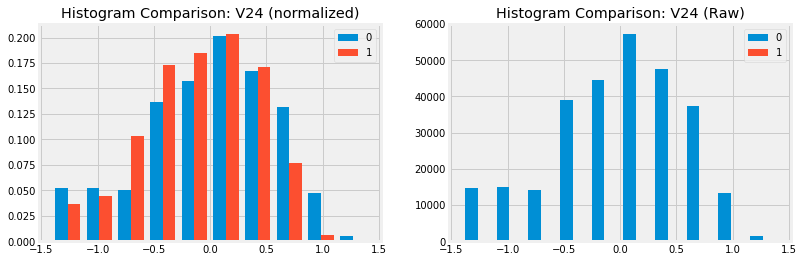

Raw Hist:
             0      1
-1.41  14764.0   18.0
-1.13  14876.0   22.0
-0.85  14185.0   51.0
-0.56  38984.0   85.0
-0.28  44656.0   91.0
 0.00  57194.0  100.0
 0.28  47456.0   84.0
 0.56  37393.0   38.0
 0.85  13457.0    3.0
 1.13   1350.0    0.0

Norm Hist:
           0      1
-1.41  0.052  0.037
-1.13  0.052  0.045
-0.85  0.050  0.104
-0.56  0.137  0.173
-0.28  0.157  0.185
 0.00  0.201  0.203
 0.28  0.167  0.171
 0.56  0.132  0.077
 0.85  0.047  0.006
 1.13  0.005  0.000

Value Counts from DF:
0    284315
1       492
Name: Class, dtype: int64

Value Counts from Hist:
0    284315.0
1       492.0
dtype: float64

-----
Col Name: V25
Total values: 284807
Floor: -1.212 (4934 values; 1.73%)
Cap: 1.212 (2766 values; 0.97%)


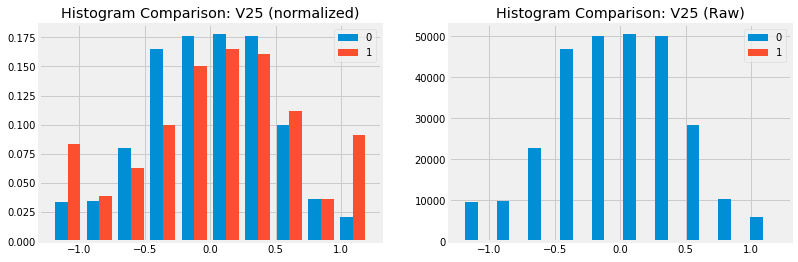

Raw Hist:
             0     1
-1.21   9519.0  41.0
-0.97   9812.0  19.0
-0.73  22816.0  31.0
-0.48  46784.0  49.0
-0.24  50157.0  74.0
 0.00  50481.0  81.0
 0.24  50090.0  79.0
 0.48  28283.0  55.0
 0.73  10385.0  18.0
 0.97   5988.0  45.0

Norm Hist:
           0      1
-1.21  0.033  0.083
-0.97  0.035  0.039
-0.73  0.080  0.063
-0.48  0.165  0.100
-0.24  0.176  0.150
 0.00  0.178  0.165
 0.24  0.176  0.161
 0.48  0.099  0.112
 0.73  0.037  0.037
 0.97  0.021  0.091

Value Counts from DF:
0    284315
1       492
Name: Class, dtype: int64

Value Counts from Hist:
0    284315.0
1       492.0
dtype: float64

-----
Col Name: V26
Total values: 284807
Floor: -1.122 (1306 values; 0.46%)
Cap: 1.122 (3764 values; 1.32%)


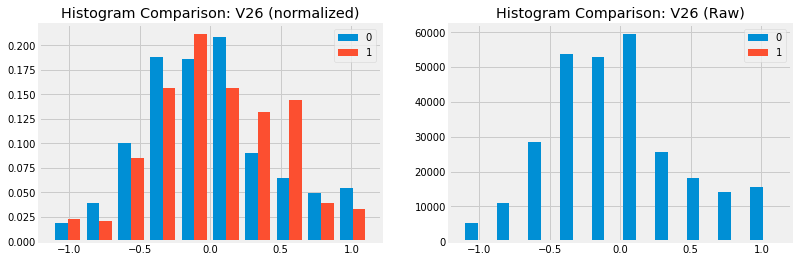

Raw Hist:
             0      1
-1.12   5343.0   11.0
-0.90  11060.0   10.0
-0.67  28578.0   42.0
-0.45  53627.0   77.0
-0.22  52868.0  104.0
 0.00  59430.0   77.0
 0.22  25520.0   65.0
 0.45  18251.0   71.0
 0.67  14064.0   19.0
 0.90  15574.0   16.0

Norm Hist:
           0      1
-1.12  0.019  0.022
-0.90  0.039  0.020
-0.67  0.101  0.085
-0.45  0.189  0.157
-0.22  0.186  0.211
 0.00  0.209  0.157
 0.22  0.090  0.132
 0.45  0.064  0.144
 0.67  0.049  0.039
 0.90  0.055  0.033

Value Counts from DF:
0    284315
1       492
Name: Class, dtype: int64

Value Counts from Hist:
0    284315.0
1       492.0
dtype: float64

-----
Col Name: V27
Total values: 284807
Floor: -0.939 (4589 values; 1.61%)
Cap: 0.939 (2816 values; 0.99%)


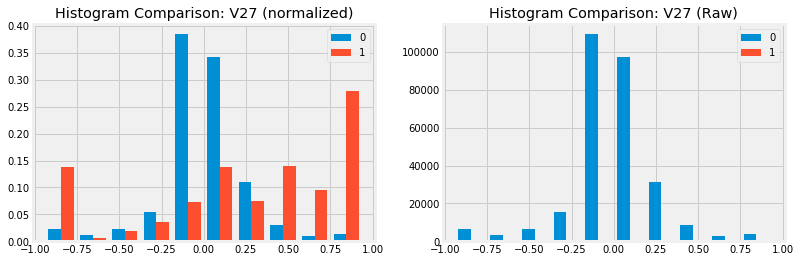

Raw Hist:
              0      1
-0.94    6354.0   68.0
-0.75    3251.0    3.0
-0.56    6380.0    9.0
-0.38   15514.0   18.0
-0.19  109371.0   36.0
-0.00   97197.0   68.0
 0.19   31143.0   37.0
 0.38    8360.0   69.0
 0.56    2701.0   47.0
 0.75    4044.0  137.0

Norm Hist:
           0      1
-0.94  0.022  0.138
-0.75  0.011  0.006
-0.56  0.022  0.018
-0.38  0.055  0.037
-0.19  0.385  0.073
-0.00  0.342  0.138
 0.19  0.110  0.075
 0.38  0.029  0.140
 0.56  0.010  0.096
 0.75  0.014  0.278

Value Counts from DF:
0    284315
1       492
Name: Class, dtype: int64

Value Counts from Hist:
0    284315.0
1       492.0
dtype: float64

-----
Col Name: V28
Total values: 284807
Floor: -0.768 (3673 values; 1.29%)
Cap: 0.768 (1577 values; 0.55%)


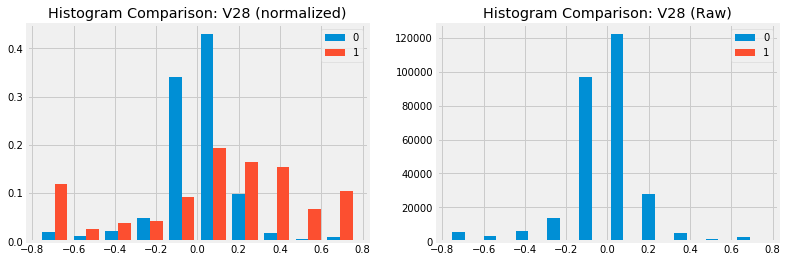

Raw Hist:
              0     1
-0.77    5317.0  58.0
-0.61    3179.0  13.0
-0.46    6228.0  19.0
-0.31   13999.0  21.0
-0.15   97009.0  45.0
-0.00  122104.0  95.0
 0.15   27692.0  81.0
 0.31    5089.0  76.0
 0.46    1436.0  33.0
 0.61    2262.0  51.0

Norm Hist:
           0      1
-0.77  0.019  0.118
-0.61  0.011  0.026
-0.46  0.022  0.039
-0.31  0.049  0.043
-0.15  0.341  0.091
-0.00  0.429  0.193
 0.15  0.097  0.165
 0.31  0.018  0.154
 0.46  0.005  0.067
 0.61  0.008  0.104

Value Counts from DF:
0    284315
1       492
Name: Class, dtype: int64

Value Counts from Hist:
0    284315.0
1       492.0
dtype: float64

-----
Col Name: Amount
Total values: 284807
Floor: -493.430 (0 values; 0.00%)
Cap: 670.129 (5935 values; 2.08%)


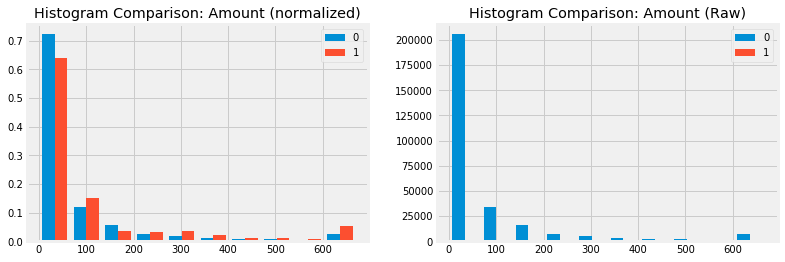

Raw Hist:
               0      1
0.00    205600.0  315.0
67.01    34307.0   74.0
134.03   15780.0   18.0
201.04    7711.0   16.0
268.05    5079.0   17.0
335.06    3422.0   10.0
402.08    2193.0    5.0
469.09    1929.0    6.0
536.10    1371.0    4.0
603.12    6923.0   27.0

Norm Hist:
            0      1
0.00    0.723  0.640
67.01   0.121  0.150
134.03  0.056  0.037
201.04  0.027  0.033
268.05  0.018  0.035
335.06  0.012  0.020
402.08  0.008  0.010
469.09  0.007  0.012
536.10  0.005  0.008
603.12  0.024  0.055

Value Counts from DF:
0    284315
1       492
Name: Class, dtype: int64

Value Counts from Hist:
0    284315.0
1       492.0
dtype: float64



In [18]:
e.compare_hists(df=data, target_col='Class', specific_cols=None, cap_floor=True)

## Data Check
- Null values?
- Normalizing?
- Incorrect values?
- Possibility of feature engineering?

In [19]:
data.Class.sum()

492

In [20]:
len(data.Class)

284807

In [21]:
data.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [22]:
from sklearn.preprocessing import StandardScaler

S = StandardScaler()

data['Time_scaled'] = S.fit_transform(X=data[['Time']])
data['Amount_scaled'] = S.fit_transform(X=data[['Amount']])

In [23]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V23,V24,V25,V26,V27,V28,Amount,Class,Time_scaled,Amount_scaled
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,-1.996583,0.560364
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,-1.996583,-0.543818
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,-1.996562,2.281605
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0,-1.996562,0.364072
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,-1.996541,-0.038057


Seems like everything's there. That makes things easy. Let's get weird.

In [26]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from xgboost import XGBClassifier

In [28]:
X = data.drop(columns=['Class'])
y = data.Class

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, stratify = y_train)

In [30]:
from MyDataTools import model

m = model()

rf0 = RandomForestClassifier(n_estimators=50)

xgb = XGBClassifier()

gb0 = GradientBoostingClassifier(n_estimators=50)

In [ ]:
m.cross_val_roc_auc_plot([rf0, gb0, pipe_rf_os, pipe_rf_us, xgb], xval = X_val, yval = y_val)

In [ ]:
m.cross_val_precision_recall_auc([rf0, gb0, pipe_rf_os, pipe_rf_us, xgb], xval = X_val, yval = y_val)

In [31]:
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

In [32]:
preds = xgb.predict(X_test)

In [33]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.94      0.73      0.82        98

   micro avg       1.00      1.00      1.00     56962
   macro avg       0.97      0.87      0.91     56962
weighted avg       1.00      1.00      1.00     56962



In [34]:
print(confusion_matrix(y_test, preds))

[[56859     5]
 [   26    72]]


In [35]:
probas = xgb.predict_proba(X_test)[:,1]

In [36]:
from sklearn.metrics import average_precision_score, recall_score, precision_score

In [37]:
average_precision_score(y_test, probas)

0.8036637536999544

In [38]:
recall_score(y_test, preds)

0.7346938775510204

In [39]:
thres = m.optimal_cutoff(y_test, probas)[0]

In [40]:
print(thres)

0.0006662164232693613


In [41]:
preds_thres = [x > thres for x in probas]

In [42]:
print(classification_report(y_test, preds_thres))
print('\n')
print(confusion_matrix(y_test, preds_thres))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97     56864
           1       0.02      0.93      0.05        98

   micro avg       0.94      0.94      0.94     56962
   macro avg       0.51      0.93      0.51     56962
weighted avg       1.00      0.94      0.96     56962



[[53187  3677]
 [    7    91]]


In [43]:
precision_score(y_test, preds)

0.935064935064935

In [45]:
from xgboost import cv, DMatrix
from sklearn.metrics import average_precision_score, make_scorer
from skopt import BayesSearchCV

avg_prec = make_scorer(average_precision_score, needs_proba=True)

In [120]:
from skopt.space import Real, Categorical, Integer
from xgboost import DMatrix, cv
from sklearn.metrics import accuracy_score, roc_auc_score

In [ ]:
xgb_space = {
    'max_depth':Integer(3,20),
    'min_child_weight':Integer(1,10),
    'subsample':[i/10.0 for i in range(6,10)],
     'gamma':[i/10.0 for i in range(0,9)],
     'colsample_bytree':[i/10.0 for i in range(3,10)]
}

In [164]:
xgb_bo1 = BayesSearchCV(estimator=xgb, 
                        search_spaces=xgb_space,
                        scoring=avg_prec,
                        n_iter=10,
                        cv=5,
                       verbose=1,
                       n_jobs=4)


xgb_bo1.fit(X_val, y_val)
xgb_bo1.best_score_, xgb_bo1.best_params_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   10.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   14.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    8.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   10.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   16.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   12.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   15.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    9.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   11.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   11.0s finished


(0.8077762728409391,
 {'colsample_bytree': 0.5,
  'gamma': 0.7,
  'max_depth': 6,
  'min_child_weight': 2,
  'subsample': 0.8})

In [165]:
xgb_bo1.best_estimator_.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.5, gamma=0.7,
       learning_rate=0.1, max_delta_step=0, max_depth=6,
       min_child_weight=2, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=0.8, verbosity=1)

In [166]:
preds_bo1 = xgb_bo1.best_estimator_.predict(X_test)

In [167]:
print(classification_report(y_test, preds_bo1))
print('\n')
print(confusion_matrix(y_test, preds_bo1))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.95      0.80      0.87        98

   micro avg       1.00      1.00      1.00     56962
   macro avg       0.98      0.90      0.93     56962
weighted avg       1.00      1.00      1.00     56962



[[56860     4]
 [   20    78]]


In [168]:
thres_bo1 = m.optimal_cutoff(y_test, xgb_bo1.best_estimator_.predict_proba(X_test)[:,1])[0]

In [169]:
print(thres_bo1)

0.0005695774452760816


In [170]:
preds_new = [x > thres_bo1 for x in xgb_bo1.best_estimator_.predict_proba(X_test)[:,1]]

In [171]:
print(classification_report(y_test, preds_new))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97     56864
           1       0.03      0.94      0.05        98

   micro avg       0.94      0.94      0.94     56962
   macro avg       0.51      0.94      0.51     56962
weighted avg       1.00      0.94      0.97     56962



In [172]:
print(confusion_matrix(y_test, preds_new))

[[53424  3440]
 [    6    92]]


In [179]:
X_test.loc[y_test.loc[y_test == 1].index]

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
64329,51112.0,-9.848776,7.365546,-12.898538,4.273323,-7.611991,-3.427045,-8.350808,6.863604,-2.387567,...,0.832398,0.931958,-0.874467,-0.192639,-0.035426,0.538665,-0.263934,1.134095,0.225973,99.99
6820,8614.0,-2.169929,3.639654,-4.508498,2.730668,-2.122693,-2.341017,-4.235253,1.703538,-1.305279,...,0.500779,0.645103,-0.503529,-0.000523,0.071696,0.092007,0.308498,0.552591,0.298954,1.00
623,472.0,-3.043541,-3.157307,1.088463,2.288644,1.359805,-1.064823,0.325574,-0.067794,-0.270953,...,2.102339,0.661696,0.435477,1.375966,-0.293803,0.279798,-0.145362,-0.252773,0.035764,529.00
201098,133731.0,1.176633,3.141918,-6.140445,5.521821,1.768515,-1.727186,-0.932429,0.292797,-3.156827,...,0.329568,0.129372,-0.803021,-0.074098,-0.031084,0.375366,0.065897,0.488258,0.325872,0.00
30398,35906.0,-3.519030,4.140867,-3.628202,5.505672,-4.057463,-0.905945,-6.652031,2.634524,-4.679402,...,0.898723,1.582556,0.778710,-0.135707,-0.004278,0.032706,0.362014,0.900925,0.554897,9.13
167305,118603.0,-6.677212,5.529299,-7.193275,6.081321,-1.636071,0.500610,-4.640770,-4.339840,-0.950036,...,-1.118687,5.563301,-1.608272,0.965322,0.163718,0.047531,0.466165,0.278547,1.471988,105.89
52521,45501.0,1.001992,0.047938,-0.349002,1.493958,0.186939,0.190966,-0.001112,0.147140,0.580415,...,0.016004,-0.334417,-1.014315,-0.128427,-0.946242,0.456090,-0.453206,0.046627,0.064698,105.99
255403,157207.0,1.170756,2.501038,-4.986159,5.374160,0.997798,-1.259004,-1.237689,0.358426,-2.612489,...,0.227618,0.123145,-0.713201,-0.080868,-0.964310,0.338568,0.068630,0.481588,0.268226,4.97
149587,91524.0,1.954852,1.630056,-4.337200,2.378367,2.113348,-1.583851,0.653745,-0.192892,1.217608,...,-0.230640,-0.474437,-0.974625,-0.048155,-0.023524,0.362192,-0.570709,0.025619,0.081880,1.00
154587,102114.0,-28.255053,21.467203,-26.871339,11.737436,-17.999630,6.065901,-41.506796,-38.987263,-13.434066,...,10.440718,-21.453736,8.361985,4.909111,0.098328,-1.508739,0.008711,-5.407824,-0.183811,0.00


In [77]:
xgb_bo2.best_estimator_.fit(X_train, y_train)

preds_bo2 = xgb_bo2.best_estimator_.predict(X_test)

print(classification_report(y_test, preds_bo2))
print('\n')
print(confusion_matrix(y_test, preds_bo2))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.94      0.73      0.82        98

   micro avg       1.00      1.00      1.00     56962
   macro avg       0.97      0.87      0.91     56962
weighted avg       1.00      1.00      1.00     56962



[[56859     5]
 [   26    72]]


In [89]:
thres_bo2 = m.optimal_cutoff(y_test, xgb_bo2.best_estimator_.predict_proba(X_test)[:,1])[0]
print(thres_bo2)
preds_new2 = [x > thres_bo2 for x in xgb_bo2.best_estimator_.predict_proba(X_test)[:,1]]
print(classification_report(y_test, preds_new2))
print('\n')
print(confusion_matrix(y_test, preds_new2))

0.000713554909452796
              precision    recall  f1-score   support

           0       1.00      0.94      0.97     56864
           1       0.03      0.94      0.05        98

   micro avg       0.94      0.94      0.94     56962
   macro avg       0.51      0.94      0.51     56962
weighted avg       1.00      0.94      0.97     56962



[[53379  3485]
 [    6    92]]


In [90]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}

xgb_bo3 = BayesSearchCV(estimator=xgb_bo2.best_estimator_, 
                        search_spaces= param_test3,
                      scoring=avg_prec,
                      n_iter=5)


xgb_bo3.fit(X_val, y_val)

C:\Users\wband\Anaconda3\envs\py36\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\wband\Anaconda3\envs\py36\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\wband\Anaconda3\envs\py36\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\wband\Anaconda3\envs\py36\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 

BayesSearchCV(cv=None, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0.0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=2, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1),
       fit_params=None, iid=True, n_iter=5, n_jobs=1, n_points=1,
       optimizer_kwargs=None, pre_dispatch='2*n_jobs', random_state=None,
       refit=True, return_train_score=False,
       scoring=make_scorer(average_precision_score, needs_proba=True),
       search_spaces={'gamma': [0.0, 0.1, 0.2, 0.3, 0.4]}, verbose=0)

In [91]:
xgb_bo3.best_estimator_.fit(X_train, y_train)

preds_bo3 = xgb_bo3.best_estimator_.predict(X_test)

print(classification_report(y_test, preds_bo3))
print('\n')
print(confusion_matrix(y_test, preds_bo3))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.94      0.73      0.82        98

   micro avg       1.00      1.00      1.00     56962
   macro avg       0.97      0.87      0.91     56962
weighted avg       1.00      1.00      1.00     56962



[[56859     5]
 [   26    72]]


In [92]:
thres_bo3 = m.optimal_cutoff(y_test, xgb_bo3.best_estimator_.predict_proba(X_test)[:,1])[0]
print(thres_bo2)
preds_new3 = [x > thres_bo2 for x in xgb_bo3.best_estimator_.predict_proba(X_test)[:,1]]
print(classification_report(y_test, preds_new3))
print('\n')
print(confusion_matrix(y_test, preds_new3))

0.000713554909452796
              precision    recall  f1-score   support

           0       1.00      0.94      0.97     56864
           1       0.03      0.93      0.05        98

   micro avg       0.94      0.94      0.94     56962
   macro avg       0.51      0.93      0.51     56962
weighted avg       1.00      0.94      0.97     56962



[[53357  3507]
 [    7    91]]
